<a href="https://colab.research.google.com/github/SatyaHarshithaDanda/Customer-Transactions-Analysis/blob/main/Customer_Transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from scipy import stats
from prophet import Prophet
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [ ]:
# Load the data from the Excel file
CTData = pd.read_excel('Customer Transactions.xlsx')

In [ ]:
print(CTData.head())

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [ ]:
xl = pd.ExcelFile('Customer Transactions.xlsx')
print("Available sheet names:", xl.sheet_names)

Available sheet names: ['Year 2009-2010', 'Year 2010-2011']


In [ ]:
  sheet1 = pd.read_excel(xl, sheet_name='Year 2009-2010')
  sheet2 = pd.read_excel(xl, sheet_name='Year 2010-2011')

In [ ]:
data = pd.concat([sheet1, sheet2])

In [ ]:
# Data preprocessing
# Convert InvoiceDate to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [ ]:
# Data Cleaning

# Handle Missing Values
data.dropna(inplace=True)  # Drop rows with missing values
# Alternatively, you can impute missing values:
# data.fillna(value, inplace=True)

# Remove Duplicates
data.drop_duplicates(inplace=True)

# Data Type Conversion
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])  # Convert to datetime format

In [ ]:
# Display the column names in your DataFrame
print(data.columns)

# Define columns to check for outliers
columns_to_check = ['Quantity', 'Price']

# Calculate z-score for each column
z_scores = stats.zscore(data[columns_to_check])

# Define threshold for outlier detection
threshold = 3

# Identify outliers
outlier_indices = (z_scores > threshold).any(axis=1)

# Remove outliers
data = data[~outlier_indices]

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


##Analysis and Modeling
Performing analysis and modeling tasks specific to each vertical within the organization

#Marketing Analysis and Strategies
##Perform RFM analysis and Customer Segmentation

RFM metrics for each customer:

    Recency: The number of days since the last purchase for each customer.
    Frequency: The total number of purchases made by each customer.
    Monetary: The total amount spent by each customer.



In [ ]:
# Calculate RFM metrics for each customer
rfm_data = data.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (pd.Timestamp.now() - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency
    'Price': 'sum'  # Monetary
}).reset_index()

In [ ]:
# Rename the columns
rfm_data.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [ ]:
# Standardize the RFM metrics (optional but recommended for clustering)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data[['Recency', 'Frequency', 'Monetary']])

In [ ]:
# Convert the standardized array back to a DataFrame
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

In [ ]:
# Determine the optimal number of clusters using the elbow method
inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

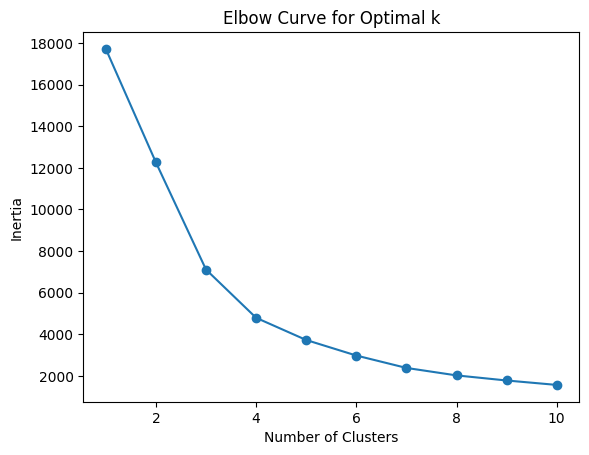

In [ ]:
# Plot the elbow curve
plt.plot(range(1, 11), inertia, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve for Optimal k')
plt.show()

In [ ]:
# Based on the elbow curve, choose the optimal number of clusters
optimal_k = 6

In [ ]:
# Perform K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_data['Cluster'] = kmeans.fit_predict(rfm_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Derive marketing strategies based on customer segments

In [ ]:
segmented_customers = rfm_data.groupby('Cluster').agg({
    'CustomerID': 'count',  # Number of customers in each segment
    'Recency': 'mean',  # Average recency
    'Frequency': 'mean',  # Average frequency
    'Monetary': 'mean'  # Average monetary value
}).reset_index()

In [ ]:
# Print segmented customers
print(segmented_customers)

   Cluster  CustomerID      Recency   Frequency      Monetary
0        0        3132  4630.954981    4.719349    235.916561
1        1        1896  5025.569620    2.543249    131.767127
2        2           9  4584.666667  205.444444  14186.536667
3        3         120  4570.533333   62.008333   2950.386025
4        4           2  4550.000000  383.500000  41022.285000
5        5         744  4582.715054   19.810484   1169.658297


In [ ]:
# Define names for all customer segments
segment_names = {
    0: 'Standard Customers',
    1: 'Frequent Customers',
    2: 'VIP Customers',
    3: 'Occasional Customers',
    4: 'Super VIP Customers',
    5: 'High Frequency Customers'
}

In [ ]:
# Update the 'Cluster' column to display the customer segment names
segmented_customers['Cluster'] = segmented_customers['Cluster'].map(segment_names)
# Print the updated DataFrame with customer segment names
print(segmented_customers)

                    Cluster  CustomerID      Recency   Frequency      Monetary
0        Standard Customers        3132  4630.954981    4.719349    235.916561
1        Frequent Customers        1896  5025.569620    2.543249    131.767127
2             VIP Customers           9  4584.666667  205.444444  14186.536667
3      Occasional Customers         120  4570.533333   62.008333   2950.386025
4       Super VIP Customers           2  4550.000000  383.500000  41022.285000
5  High Frequency Customers         744  4582.715054   19.810484   1169.658297


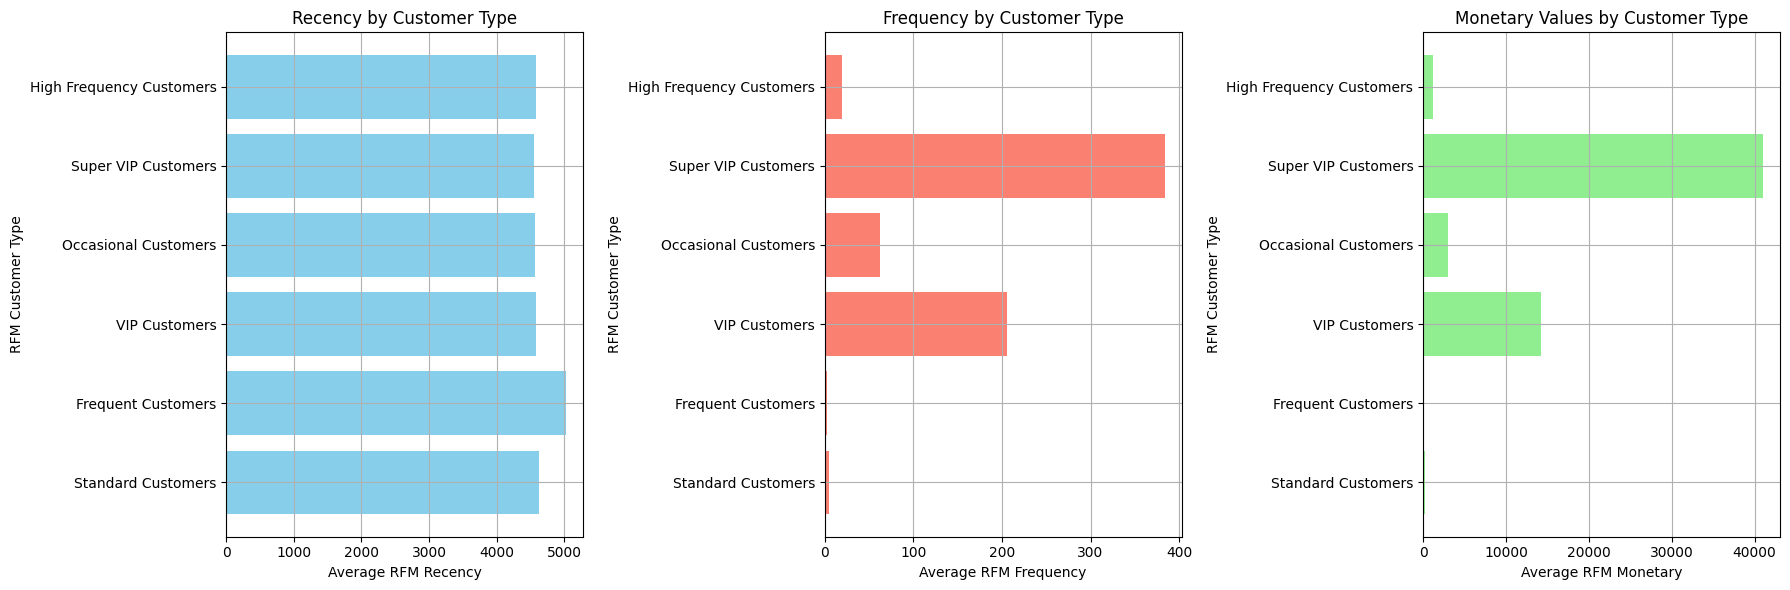

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plotting Graph 1: Recency by Customer Type
axes[0].barh(segmented_customers['Cluster'], segmented_customers['Recency'], color='skyblue')
axes[0].set_ylabel('RFM Customer Type')
axes[0].set_xlabel('Average RFM Recency')
axes[0].set_title('Recency by Customer Type')
axes[0].set_yticks(segmented_customers['Cluster'])
axes[0].grid(True)

# Plotting Graph 2: Frequency by Customer Type
axes[1].barh(segmented_customers['Cluster'], segmented_customers['Frequency'], color='salmon')
axes[1].set_ylabel('RFM Customer Type')
axes[1].set_xlabel('Average RFM Frequency')
axes[1].set_title('Frequency by Customer Type')
axes[1].set_yticks(segmented_customers['Cluster'])
axes[1].grid(True)

# Plotting Graph 3: Monetary Values by Customer Type
axes[2].barh(segmented_customers['Cluster'], segmented_customers['Monetary'], color='lightgreen')
axes[2].set_ylabel('RFM Customer Type')
axes[2].set_xlabel('Average RFM Monetary')
axes[2].set_title('Monetary Values by Customer Type')
axes[2].set_yticks(segmented_customers['Cluster'])
axes[2].grid(True)

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()


#Operation Team Analysis and Strategies
##Build a sales forecasting model


In [ ]:
# Convert InvoiceDate to datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [ ]:
# Extract relevant columns and aggregate sales data by date and country
sales_data = data[['InvoiceDate', 'Country', 'Quantity']].copy()
daily_sales_country = sales_data.groupby([sales_data['InvoiceDate'].dt.date, 'Country'])['Quantity'].sum().reset_index()

In [ ]:
# Rename columns to match Prophet's requirements
daily_sales_country.columns = ['ds', 'Country', 'y']

In [ ]:
# Function to forecast sales for a given country
def forecast_sales_by_country(country_df, periods=60):
    model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    model.fit(country_df)
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    return model, forecast

In [ ]:
# Create an empty dictionary to store forecasts and models
forecasts = {}
models = {}

In [ ]:
# Define the minimum number of data points required for training
min_data_points = 30

In [ ]:
# Forecast sales for each country
for country in daily_sales_country['Country'].unique():
    country_df = daily_sales_country[daily_sales_country['Country'] == country][['ds', 'y']]
    if country_df.shape[0] >= min_data_points:
        model, forecast = forecast_sales_by_country(country_df)
        forecasts[country] = forecast
        models[country] = model

DEBUG:cmdstanpy:input tempfile: /tmp/tmplr3zd9vn/dshnoubd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplr3zd9vn/gxp2x4ma.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59211', 'data', 'file=/tmp/tmplr3zd9vn/dshnoubd.json', 'init=/tmp/tmplr3zd9vn/gxp2x4ma.json', 'output', 'file=/tmp/tmplr3zd9vn/prophet_model10vt6htw/prophet_model-20240524052211.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:22:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:22:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmplr3zd9vn/lsn1zu5p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplr3zd9vn/ylusw7j_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

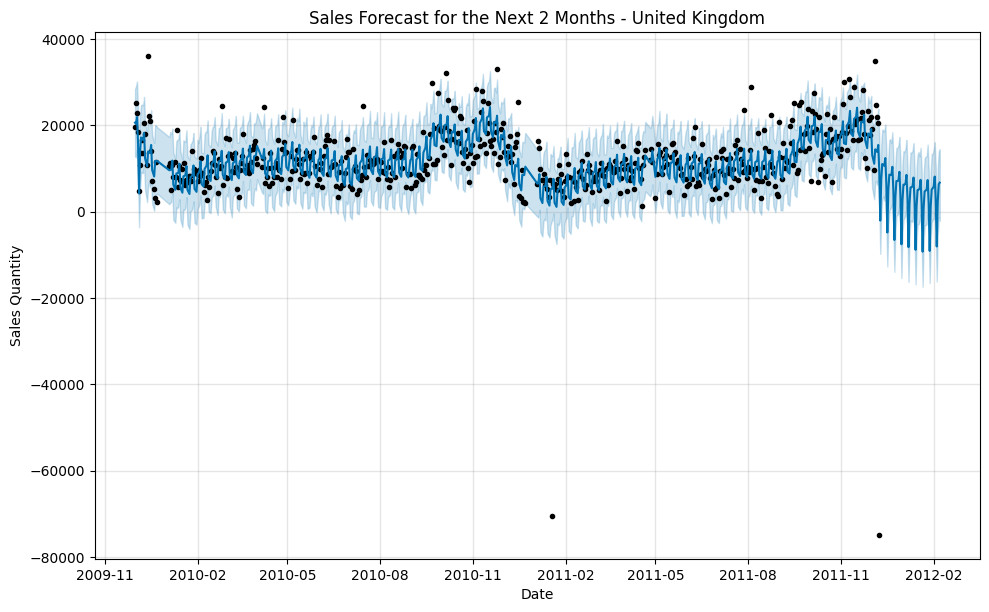

In [ ]:
# Plot the forecast for a specific country (e.g., 'United Kingdom')
country_to_plot = 'United Kingdom'
if country_to_plot in forecasts:
    model = models[country_to_plot]
    forecast = forecasts[country_to_plot]
    fig = model.plot(forecast)
    plt.title(f'Sales Forecast for the Next 2 Months - {country_to_plot}')
    plt.xlabel('Date')
    plt.ylabel('Sales Quantity')
    plt.show()

In [ ]:
# Extract forecasted sales for the next 2 months for all countries
forecast_next_2_months = {}
for country, forecast in forecasts.items():
    forecast_next_2_months[country] = forecast[['ds', 'yhat']].tail(60)

In [ ]:
# Print the forecast for the next 2 months for a specific country (e.g., 'United Kingdom')
if country_to_plot in forecast_next_2_months:
    print(forecast_next_2_months[country_to_plot])

            ds          yhat
604 2011-12-10  -2072.315283
605 2011-12-11   7603.840076
606 2011-12-12  11045.943501
607 2011-12-13  10792.760332
608 2011-12-14  10676.678824
609 2011-12-15  12422.292620
610 2011-12-16   6577.570009
611 2011-12-17  -4833.198776
612 2011-12-18   4989.182821
613 2011-12-19   8579.574601
614 2011-12-20   8475.166878
615 2011-12-21   8506.880889
616 2011-12-22  10397.954400
617 2011-12-23   4695.112918
618 2011-12-24  -6578.481709
619 2011-12-25   3375.354192
620 2011-12-26   7090.584347
621 2011-12-27   7103.621609
622 2011-12-28   7244.730848
623 2011-12-29   9236.617794
624 2011-12-30   3625.604189
625 2011-12-31  -7565.419143
626 2012-01-01   2461.597950
627 2012-01-02   6240.627832
628 2012-01-03   6308.238299
629 2012-01-04   6494.998596
630 2012-01-05   8524.069874
631 2012-01-06   2942.379898
632 2012-01-07  -8226.426844
633 2012-01-08   1816.595149
634 2012-01-09   5606.445994
635 2012-01-10   5680.840758
636 2012-01-11   5871.598835
637 2012-01-12

In [ ]:
# Deriving Inventory Management Strategies for the specific country
if country_to_plot in forecast_next_2_months:
    average_daily_sales_forecast = forecast_next_2_months[country_to_plot]['yhat'].mean()
    recommended_stock_level = average_daily_sales_forecast * 1.10
    print(f"Recommended daily stock level for {country_to_plot}: {recommended_stock_level:.2f}")

Recommended daily stock level for United Kingdom: 4299.47


In [ ]:
# Initialize and fit the Prophet model
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(daily_sales_country)

DEBUG:cmdstanpy:input tempfile: /tmp/tmplr3zd9vn/a7t0sy_d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplr3zd9vn/hs7hhkz8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35913', 'data', 'file=/tmp/tmplr3zd9vn/a7t0sy_d.json', 'init=/tmp/tmplr3zd9vn/hs7hhkz8.json', 'output', 'file=/tmp/tmplr3zd9vn/prophet_modelp7iue4h8/prophet_model-20240524052453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:24:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:24:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Make a dataframe to hold predictions for the next 3 months (90 days)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

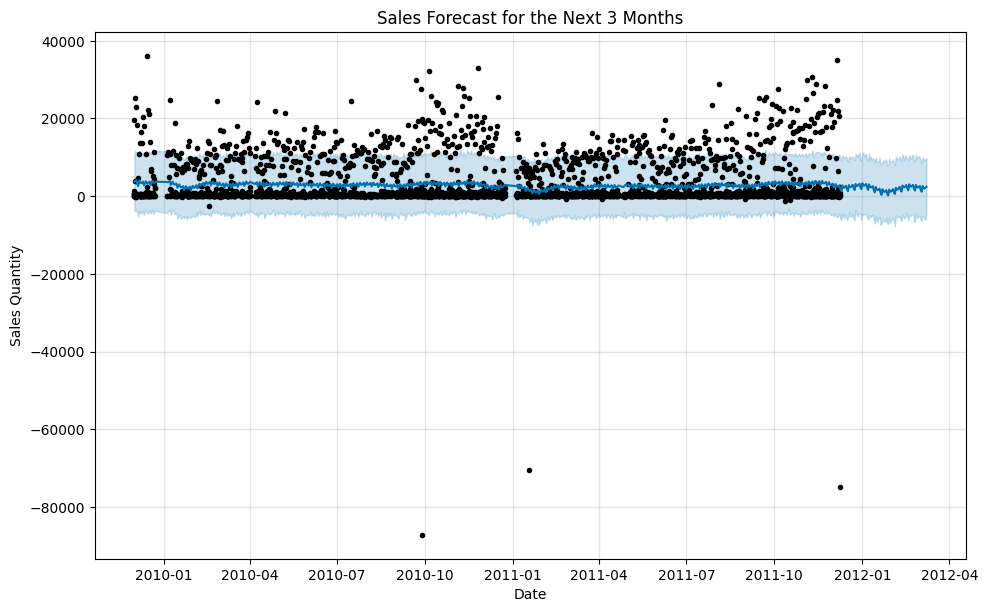

In [ ]:
# Plot the forecast
fig = model.plot(forecast)
plt.title('Sales Forecast for the Next 3 Months')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.show()

In [ ]:
# Extract forecasted sales for the next 3 months
forecast_next_3_months = forecast[['ds', 'yhat']].tail(90)
print(forecast_next_3_months)

            ds         yhat
604 2011-12-10  1311.635956
605 2011-12-11  2796.537334
606 2011-12-12  2226.515901
607 2011-12-13  2178.182990
608 2011-12-14  2385.625920
..         ...          ...
689 2012-03-04  2613.383859
690 2012-03-05  2031.782001
691 2012-03-06  1969.097143
692 2012-03-07  2159.982646
693 2012-03-08  2423.641908

[90 rows x 2 columns]


Inventory Management Strategies

In [ ]:
# Assuming we need to maintain an average stock level that is 10% above the forecasted sales
average_daily_sales_forecast = forecast_next_3_months['yhat'].mean()
recommended_stock_level = average_daily_sales_forecast * 1.10
print(f"Recommended daily stock level: {recommended_stock_level:.2f}")

Recommended daily stock level: 2252.20


##Derive inventory management strategies based on sales forecasts

In [ ]:
inventory_management_strategies = """
Based on the sales forecast for the next 3 months, the following inventory management strategies are recommended:
1. Maintain an average stock level that is 10% above the forecasted daily sales.
2. Regularly monitor sales trends and adjust stock levels accordingly.
3. Implement just-in-time inventory practices to reduce holding costs.
4. Optimize order quantities and reorder points based on the forecasted sales.
5. Consider seasonal variations and promotional periods when planning inventory.
"""

In [ ]:
print(inventory_management_strategies)


Based on the sales forecast for the next 3 months, the following inventory management strategies are recommended:
1. Maintain an average stock level that is 10% above the forecasted daily sales.
2. Regularly monitor sales trends and adjust stock levels accordingly.
3. Implement just-in-time inventory practices to reduce holding costs.
4. Optimize order quantities and reorder points based on the forecasted sales.
5. Consider seasonal variations and promotional periods when planning inventory.



In [ ]:
# Extract relevant columns and aggregate total company sales data by date
total_sales = data.groupby(data['InvoiceDate'].dt.date)['Quantity'].sum().reset_index()

# Rename columns to match Prophet's requirements
total_sales.columns = ['ds', 'y']

In [ ]:
# Forecast future sales
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(total_sales)

DEBUG:cmdstanpy:input tempfile: /tmp/tmplr3zd9vn/zc5mji94.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplr3zd9vn/wmw43q21.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48358', 'data', 'file=/tmp/tmplr3zd9vn/zc5mji94.json', 'init=/tmp/tmplr3zd9vn/wmw43q21.json', 'output', 'file=/tmp/tmplr3zd9vn/prophet_modeldilp1gl5/prophet_model-20240524052531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:25:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:25:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Determine the last observed date
last_date = pd.to_datetime(total_sales['ds'].max())

In [ ]:
# Create future dataframe starting from the last observed date
future = model.make_future_dataframe(periods=60, freq='D', include_history=False)
future = future[future['ds'] > last_date]

In [ ]:
# Forecast sales for the future dates
forecast = model.predict(future)

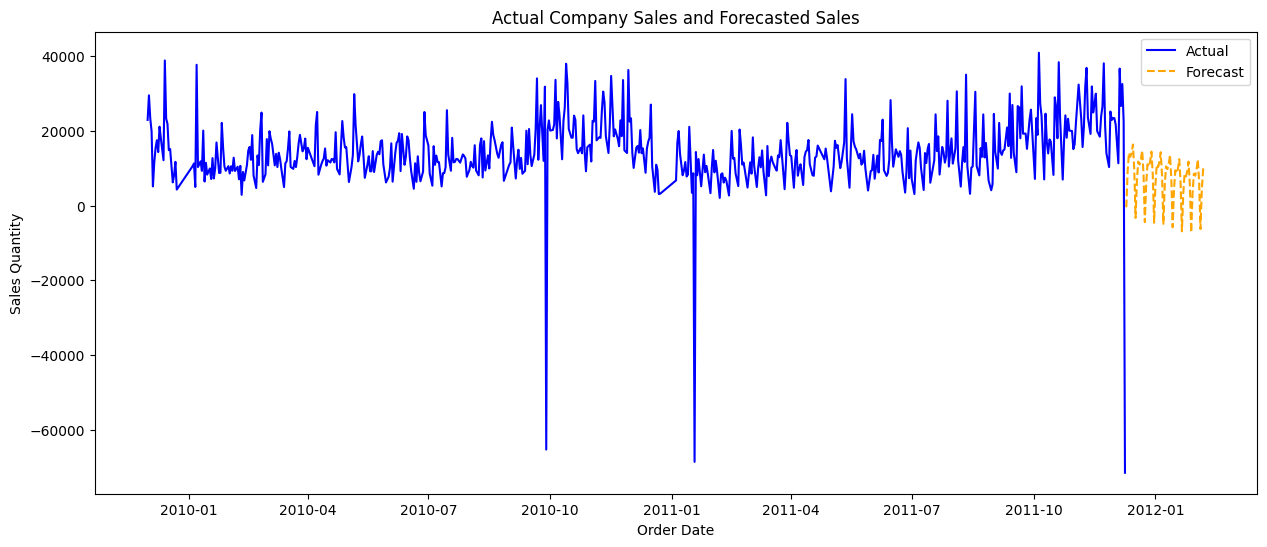

In [ ]:
# Plotting
plt.figure(figsize=(15, 6))
plt.plot(total_sales['ds'], total_sales['y'], label='Actual', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linestyle='dashed', color='orange')
plt.title('Actual Company Sales and Forecasted Sales')
plt.xlabel('Order Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.show()

#Retail Products Team
##Shelf Arrangement for Cross-sell and Up-sell

In [ ]:
# Filter out returns (negative quantities)
data = data[data['Quantity'] > 0]

In [ ]:
# Identify the top 10 selling products by quantity
top_10_products = data.groupby('StockCode')['Quantity'].sum().nlargest(10).index

In [ ]:
# Create a basket matrix for calculating the ABI index
basket_matrix = data[data['StockCode'].isin(top_10_products)].pivot_table(
    index='Invoice', columns='StockCode', values='Quantity', aggfunc='sum', fill_value=0
)

In [ ]:
# Calculate ABI index
def calculate_abi(matrix, product):
    other_products = matrix.drop(columns=[product])
    abi_scores = other_products.apply(lambda x: (x > 0).sum(), axis=0) / (matrix[product] > 0).sum()
    return abi_scores

In [ ]:
# Get ABI index for each top-selling product
abi_indices = {}
for product in top_10_products:
    abi_indices[product] = calculate_abi(basket_matrix, product)

In [ ]:
# Convert ABI indices to a DataFrame
abi_df = pd.DataFrame(abi_indices).transpose()
abi_df.fillna(0, inplace=True)

In [ ]:
# Ensure unique product names mapping
product_names = data.drop_duplicates(subset='StockCode').set_index('StockCode')['Description']

In [ ]:
# Mapping StockCodes to product names
abi_df.index = abi_df.index.map(product_names)
abi_df.columns = abi_df.columns.map(product_names)

In [ ]:
print("ABI Index DataFrame:")
print(abi_df)

ABI Index DataFrame:
StockCode                           BROCADE RING PURSE   \
WORLD WAR 2 GLIDERS ASSTD DESIGNS              0.447600   
WHITE HANGING HEART T-LIGHT HOLDER             0.085087   
JUMBO BAG RED WHITE SPOTTY                     0.114422   
PACK OF 72 RETRO SPOT CAKE CASES               0.146568   
POPCORN HOLDER , SMALL                         0.196222   
ASSORTED COLOUR BIRD ORNAMENT                  0.162749   
PAPER CRAFT , LITTLE BIRDIE                  457.000000   
MEDIUM CERAMIC TOP STORAGE JAR                 1.850202   
BROCADE RING PURSE                             0.000000   
PACK OF 60 PINK PAISLEY CAKE CASES             0.229303   

StockCode                           PACK OF 72 RETRO SPOT CAKE CASES  \
WORLD WAR 2 GLIDERS ASSTD DESIGNS                           3.053869   
WHITE HANGING HEART T-LIGHT HOLDER                          0.580525   
JUMBO BAG RED WHITE SPOTTY                                  0.780671   
PACK OF 72 RETRO SPOT CAKE CASES         

In [ ]:
# Recommend the next best product in line for each top-selling product
next_best_products = abi_df.idxmax(axis=1)
next_best_products_df = pd.DataFrame(next_best_products, columns=['Next Best Product'])
next_best_products_df['ABI Index'] = abi_df.max(axis=1)

In [ ]:
print("Next Best Products Recommendations:")
print(next_best_products_df)

Next Best Products Recommendations:
                                                     Next Best Product  \
WORLD WAR 2 GLIDERS ASSTD DESIGNS   WHITE HANGING HEART T-LIGHT HOLDER   
WHITE HANGING HEART T-LIGHT HOLDER         JUMBO BAG RED WHITE SPOTTY    
JUMBO BAG RED WHITE SPOTTY          WHITE HANGING HEART T-LIGHT HOLDER   
PACK OF 72 RETRO SPOT CAKE CASES    WHITE HANGING HEART T-LIGHT HOLDER   
POPCORN HOLDER , SMALL              WHITE HANGING HEART T-LIGHT HOLDER   
ASSORTED COLOUR BIRD ORNAMENT       WHITE HANGING HEART T-LIGHT HOLDER   
PAPER CRAFT , LITTLE BIRDIE         WHITE HANGING HEART T-LIGHT HOLDER   
MEDIUM CERAMIC TOP STORAGE JAR      WHITE HANGING HEART T-LIGHT HOLDER   
BROCADE RING PURSE                  WHITE HANGING HEART T-LIGHT HOLDER   
PACK OF 60 PINK PAISLEY CAKE CASES  WHITE HANGING HEART T-LIGHT HOLDER   

                                      ABI Index  
WORLD WAR 2 GLIDERS ASSTD DESIGNS      5.260529  
WHITE HANGING HEART T-LIGHT HOLDER     0.743623  

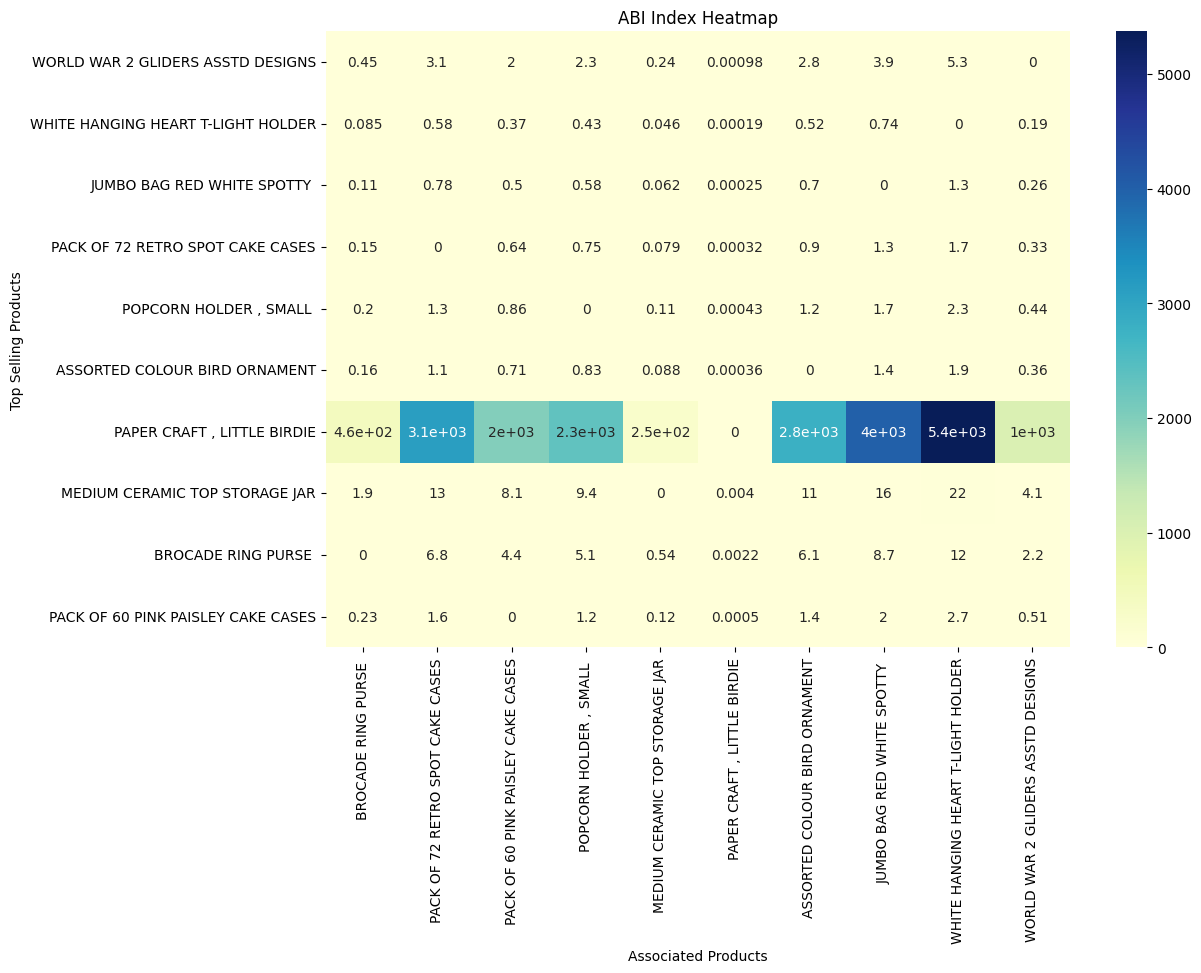

In [ ]:
# Visualization of ABI indices
plt.figure(figsize=(12, 8))
sns.heatmap(abi_df, annot=True, cmap='YlGnBu')
plt.title('ABI Index Heatmap')
plt.xlabel('Associated Products')
plt.ylabel('Top Selling Products')
plt.show()

In [ ]:
# Ensure the data is sorted by date
data.sort_values(by='InvoiceDate', inplace=True)

In [ ]:
# Calculate weekly sales for each product
weekly_sales = data.set_index('InvoiceDate').groupby([pd.Grouper(freq='W'), 'StockCode'])['Quantity'].sum().unstack().fillna(0)

In [ ]:
# Mapping StockCodes to product names for visualization
weekly_sales.columns = weekly_sales.columns.map(product_names)

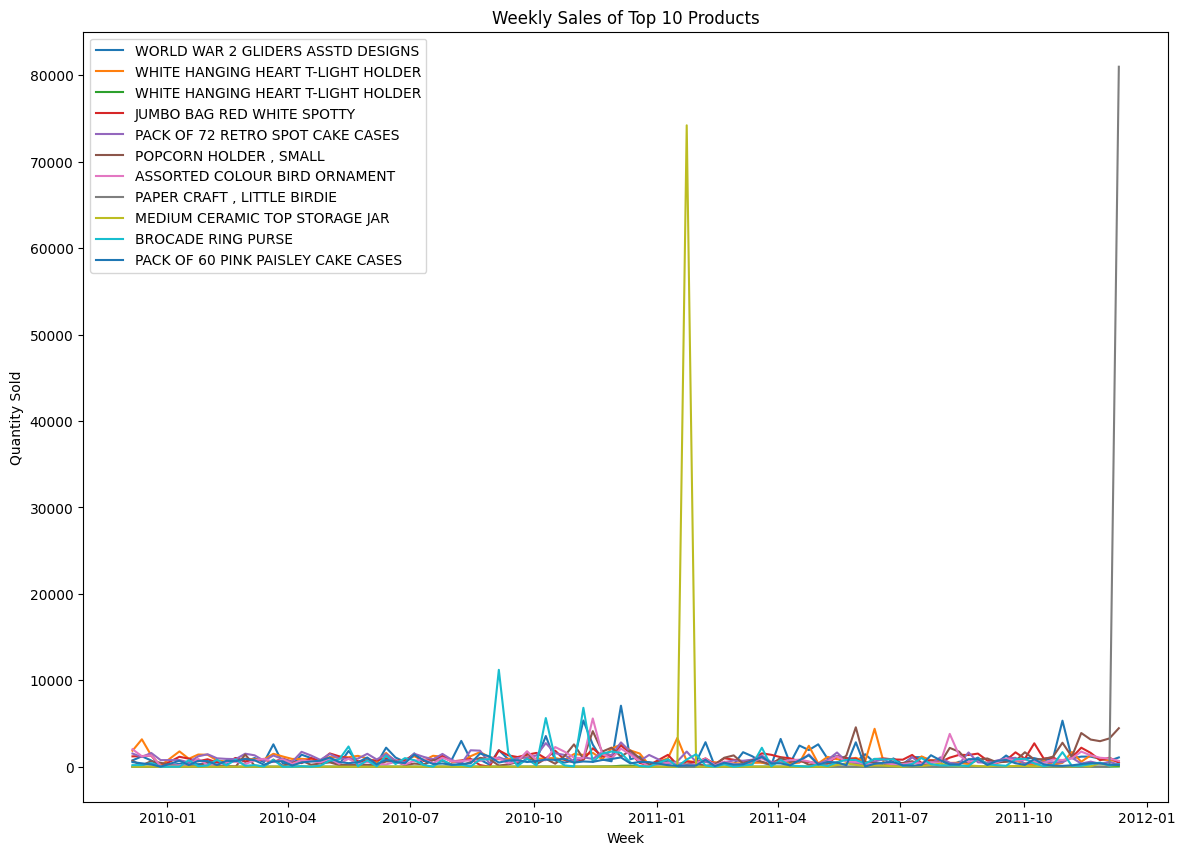

In [ ]:
# Plot weekly sales for the top 10 products
plt.figure(figsize=(14, 10))
for product in abi_df.index:
    plt.plot(weekly_sales.index, weekly_sales[product], label=product)
plt.title('Weekly Sales of Top 10 Products')
plt.xlabel('Week')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()

In [ ]:
# Example strategy recommendation for shelf arrangement
for product in abi_df.index:
    next_best = next_best_products_df.loc[product, 'Next Best Product']
    abi_value = next_best_products_df.loc[product, 'ABI Index']
    print(f"Place product {next_best} next to {product} (ABI Index: {abi_value:.2f}) to encourage cross-selling.")

Place product WHITE HANGING HEART T-LIGHT HOLDER next to WORLD WAR 2 GLIDERS ASSTD DESIGNS (ABI Index: 5.26) to encourage cross-selling.
Place product JUMBO BAG RED WHITE SPOTTY  next to WHITE HANGING HEART T-LIGHT HOLDER (ABI Index: 0.74) to encourage cross-selling.
Place product WHITE HANGING HEART T-LIGHT HOLDER next to JUMBO BAG RED WHITE SPOTTY  (ABI Index: 1.34) to encourage cross-selling.
Place product WHITE HANGING HEART T-LIGHT HOLDER next to PACK OF 72 RETRO SPOT CAKE CASES (ABI Index: 1.72) to encourage cross-selling.
Place product WHITE HANGING HEART T-LIGHT HOLDER next to POPCORN HOLDER , SMALL  (ABI Index: 2.31) to encourage cross-selling.
Place product WHITE HANGING HEART T-LIGHT HOLDER next to ASSORTED COLOUR BIRD ORNAMENT (ABI Index: 1.91) to encourage cross-selling.
Place product WHITE HANGING HEART T-LIGHT HOLDER next to PAPER CRAFT , LITTLE BIRDIE (ABI Index: 5371.00) to encourage cross-selling.
Place product WHITE HANGING HEART T-LIGHT HOLDER next to MEDIUM CERAMIC

In [ ]:
# Generate Churn Label
data['ChurnLabel'] = np.random.randint(0, 2, size=len(data))

In [ ]:
# Handle missing values and duplicates
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

In [ ]:
# Feature engineering: Extract relevant features
data['Month'] = data['InvoiceDate'].dt.to_period('M')
monthly_data = data.groupby(['Customer ID', 'Country', 'Month']).agg({
    'Invoice': 'nunique',  # Number of transactions
    'Quantity': 'sum',       # Total quantity purchased
    'Price': 'mean',     # Average unit price
    'ChurnLabel': 'max'      # Churn label
}).reset_index()

In [ ]:
# Rename columns
monthly_data.rename(columns={
    'Invoice': 'NumTransactions',
    'Quantity': 'TotalQuantity',
    'Price': 'AvgUnitPrice'
}, inplace=True)

In [ ]:
# Feature scaling
scaler = StandardScaler()
monthly_data[['NumTransactions', 'TotalQuantity', 'AvgUnitPrice']] = scaler.fit_transform(
    monthly_data[['NumTransactions', 'TotalQuantity', 'AvgUnitPrice']]
)

Build and Train the Churn Prediction Model

In [ ]:
# Split the data into train and test sets
X = monthly_data[['NumTransactions', 'TotalQuantity', 'AvgUnitPrice']]
y = monthly_data['ChurnLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Build a logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [ ]:
# Predict probabilities
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [ ]:
# Evaluate the model using ROC-AUC and F1-score
roc_auc = roc_auc_score(y_test, y_pred_prob)
f1 = f1_score(y_test, model.predict(X_test))

In [ ]:
print(f'ROC-AUC: {roc_auc:.2f}')
print(f'F1 Score: {f1:.2f}')

ROC-AUC: 0.79
F1 Score: 0.99


Identify Customers with the Highest Churn Probability

In [ ]:
# Add predictions to the test set
test_results = X_test.copy()
test_results['ChurnProbability'] = y_pred_prob
test_results['ChurnLabel'] = y_test

In [ ]:
# Sort customers by churn probability
high_churn_customers = test_results.sort_values(by='ChurnProbability', ascending=False).head(10)

In [ ]:
print("Top 10 Customers with Highest Churn Probability:")
print(high_churn_customers)

Top 10 Customers with Highest Churn Probability:
       NumTransactions  TotalQuantity  AvgUnitPrice  ChurnProbability  \
11320        17.181854       7.602840     -0.018150               1.0   
8454         -0.338212      51.463964     -0.054456               1.0   
6735          0.423530      55.060723     -0.053257               1.0   
23855        29.369725       2.805974     -0.032644               1.0   
1729         17.943596       2.101216     -0.033958               1.0   
11321        24.799273       7.146645     -0.013450               1.0   
22067        15.658370       3.133438     -0.035879               1.0   
11301        12.611402       3.087759      0.009812               1.0   
10090         5.755724       9.963306     -0.037458               1.0   
23853        13.373144       1.612987     -0.027508               1.0   

       ChurnLabel  
11320           1  
8454            1  
6735            1  
23855           1  
1729            1  
11321           1  
22067  

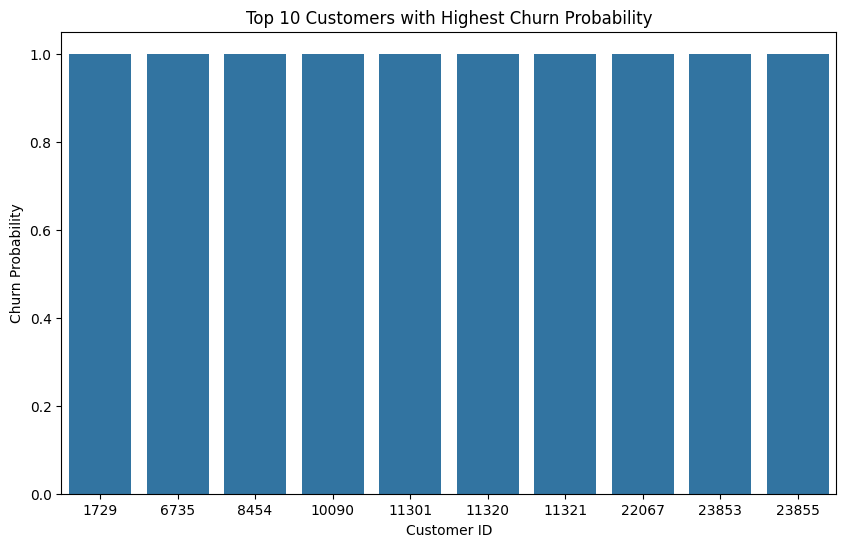

In [ ]:
# Visualization: Identify customers with the highest churn probability
plt.figure(figsize=(10, 6))
sns.barplot(x=high_churn_customers.index, y='ChurnProbability', data=high_churn_customers)
plt.title('Top 10 Customers with Highest Churn Probability')
plt.xlabel('Customer ID')
plt.ylabel('Churn Probability')
plt.show()

In [ ]:
# Derive retention initiatives
retention_initiatives = high_churn_customers.copy()
retention_initiatives['RetentionInitiative'] = 'Send personalized offers or discounts'

In [ ]:
print("\nRetention Initiatives:")
print(retention_initiatives[['ChurnProbability', 'RetentionInitiative']])


Retention Initiatives:
       ChurnProbability                    RetentionInitiative
11320               1.0  Send personalized offers or discounts
8454                1.0  Send personalized offers or discounts
6735                1.0  Send personalized offers or discounts
23855               1.0  Send personalized offers or discounts
1729                1.0  Send personalized offers or discounts
11321               1.0  Send personalized offers or discounts
22067               1.0  Send personalized offers or discounts
11301               1.0  Send personalized offers or discounts
10090               1.0  Send personalized offers or discounts
23853               1.0  Send personalized offers or discounts


In [ ]:
# Calculate monthly churn rate
monthly_churn_rate = monthly_data.groupby('Month')['ChurnLabel'].mean()

In [ ]:
print(monthly_churn_rate)

Month
2009-12    0.974869
2010-01    0.973611
2010-02    0.976744
2010-03    0.976348
2010-04    0.975584
2010-05    0.971044
2010-06    0.965418
2010-07    0.963402
2010-08    0.976948
2010-09    0.972052
2010-10    0.976651
2010-11    0.980087
2010-12    0.986456
2011-01    0.978408
2011-02    0.968379
2011-03    0.975359
2011-04    0.975467
2011-05    0.977273
2011-06    0.974773
2011-07    0.973656
2011-08    0.971123
2011-09    0.979479
2011-10    0.981685
2011-11    0.981381
2011-12    0.972358
Freq: M, Name: ChurnLabel, dtype: float64


In [ ]:
# Monthly churn rate data
data = {
    'Month': ['2009-12', '2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06', '2010-07',
              '2010-08', '2010-09', '2010-10', '2010-11', '2010-12', '2011-01', '2011-02', '2011-03',
              '2011-04', '2011-05', '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12'],
    'Churn Rate': [0.974869, 0.973611, 0.976744, 0.976348, 0.975584, 0.971044, 0.965418, 0.963402, 0.976948,
                   0.972052, 0.976651, 0.980087, 0.986456, 0.978408, 0.968379, 0.975359, 0.975467, 0.977273,
                   0.974773, 0.973656, 0.971123, 0.979479, 0.981685, 0.981381, 0.972358]
}

In [ ]:
# Create DataFrame
monthly_data = pd.DataFrame(data)

In [ ]:
# Convert month names to datetime format for better formatting
monthly_data['Month'] = pd.to_datetime(monthly_data['Month'], format='%Y-%m')
# Extract month names in the format 'Dec 2009'
monthly_data['Month'] = monthly_data['Month'].dt.strftime('%b %Y')

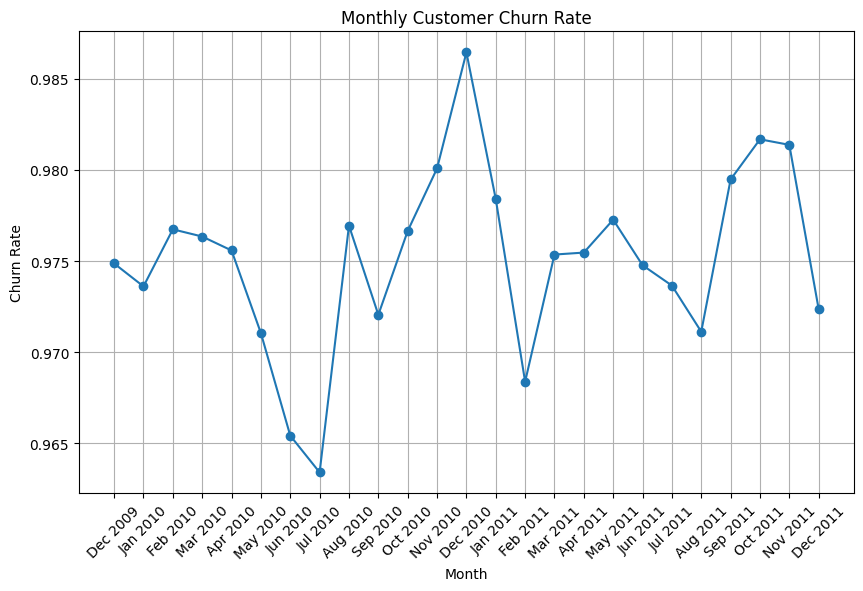

In [ ]:
# Plot monthly churn rate
plt.figure(figsize=(10, 6))
plt.plot(monthly_data['Month'], monthly_data['Churn Rate'], marker='o', linestyle='-')
plt.title('Monthly Customer Churn Rate')
plt.xlabel('Month')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()